# Timo's notes on PyTorch
PyTorch is a toolkit for working with computational graphs and performing backpropagation in them via automatic computation of gradients. Therefore, PyTorch is a great starting point for NNs and --once one surpasses the basics-- is a good base for producing well-designed and structured, object-oriented neural network code.

This notebook consolidates my ideas (in an executable form) for teaching neural networks with PyTorch (including the very basics and with a focus on NLP). 

[//]: # "I have (quite extensive) prior experience in using DyNet, as well as experience of teaching neural networks. "

The following is organized as follows:
* a very basic computational graph with minimal loss computation, backpropagation of error and gradient descent *without PyTorch*
* the same but now using PyTorch
* the same but based on `torch.nn.Module`
* [something minimal to train for MNIST (just because)](MNIST.ipynb)
* [an RNN that classifies character sequences](RNN.ipynb) for being one class or the other (e.g. words as verbs/adjectives)
* implement embeddings, see performance improvement
* use built-in embeddings and compare results
* RNN encoder for classification (with or without embedding)
* decode fixed representation to sequence
* combined encoder-decoder
* combined encoder-decoder with attention

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# i tried this with Python 3.10 on Ubuntu 22.04 (im-kigs); PyTorch is 2.0.1 with CUDA 11.7

In [8]:
# we will often repeatedly use some code for plotting. We define this once to be re-used later.
def plot(plot_data):
    plt.figure("evolution over training iterations")
    for type in plot_data.keys():
       plt.plot(plot_data[type], label=type)
    plt.legend(loc='upper right')

## A very basic computational graph. 

The idea is that we have a parameter (our estimate) and a target that we want to match. Note that in typical applications, we also have inputs (which we don't have here) and many different target values and that the model is to understand the relation between inputs and target values. 

We compute the error of the model as the quadratic loss between model estimate and target. We then backpropagate the error to the (only) parameter. We then update the parameter using gradient descent (with a learning rate of 0.01). Estimate, target and quadratic error are displayed below.

It may be interesting to check for differences when varying the learning rate. 

Also, the code as-is assumes that the target signal is always "perfect" at 5.0. Uncomment the line that sets target to roughly 5 (adding Gaussian noise) and check the influence on your results.

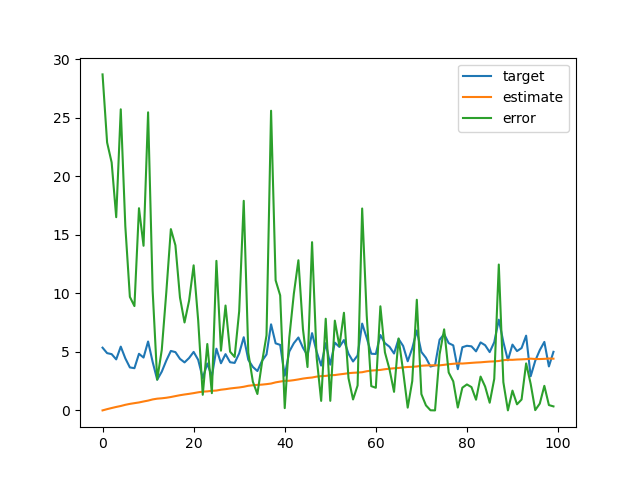

In [10]:
# how about a minimal example: 
# We have one input (let's fix it to 5?) and one parameter. 
# The goal is to use gradient descent to minimize the squared difference between parameter and input. 
# possible extension: add some noise to the input
%matplotlib widget
target = 5.
estimate = 0.

learning_rate = 0.01
plot_data = defaultdict(lambda : [])

def loss(estimate, target):
    '''
    very standard quadratic loss. 
    In fact, this loss function is of course readily available in pytorch. 
    '''
    return (target - estimate) ** 2

def gradient_of_loss_wrt_estimate(estimate, target):
    return 2 * (target - estimate)

# in gradient descent, we take many small steps (here: 100) and repeatedly change 
# the estimate according to the derivative of the parameters wrt to the error 
# using a small learning rate (which increases the number of steps necessary but 
# makes learning more robust to noise). 
# an alternative to a predetermined number of steps is checking performance on held-out
# data and stopping after no improvements occur, or stopping once the loss stops to improve.
for _ in range(100):
    # target = np.random.normal(5., 1.) # this version varies the input (what you get with "data" drawn from some underlying distribution
    error = loss(estimate, target)
    plot_data["target"].append(target)
    plot_data["estimate"].append(estimate)
    plot_data["error"].append(error)
    derivative_of_error = gradient_of_loss_wrt_estimate(estimate, target)
    estimate += learning_rate * derivative_of_error 

plot(plot_data)

The example above is "pure python", i.e., it doesn't use anything specific for training neural networks. (We do use numpy to draw from a normal distribution, but that's just because I'm too lazy to implement this myself.)

## A computational graph with Torch.

In the next example, we automate the computation of gradients and the updating of the parameter. We do this by integrating torch into the process:
* instead of defining our target and estimate as regular float values, we define them via torch (as `tensors`)
* torch already has a definition for our loss function, how convenient!
* what's exciting about torch is its ability to compute the gradient by itself based on the operations that the tensors are involved in. We don't need to worry about this at all! Instead, we simply call the `.backward()` on the loss that we want to compute the derivatives for.
* we also define an `optimizer` that is passed the learning rate. The optimizer uses the gradients stored with the parameter tensors so they can be updated. There is a multitude of optimizers, we'll use the most simple one (the same as above).

The code now looks as follows.

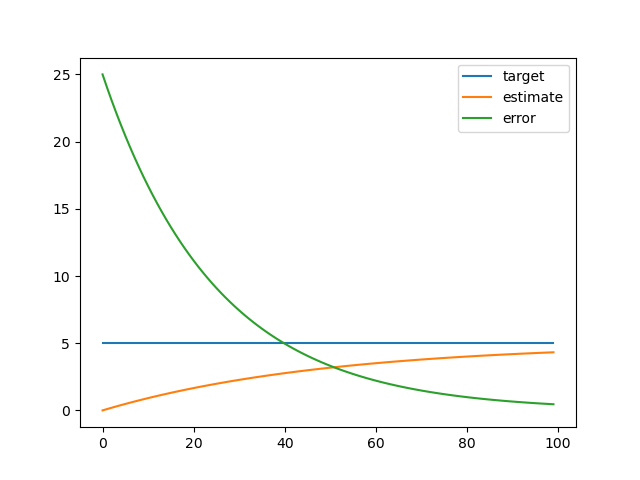

In [15]:
%matplotlib widget
target = torch.tensor([5.])
estimate = torch.tensor([0.], requires_grad = True)
learning_rate = 0.01
plot_data = defaultdict(lambda : [])

optimizer = torch.optim.SGD([estimate], lr = learning_rate)

def loss(estimate, target):
    '''
    very standard quadratic loss. 
    In fact, this loss function is of course readily available in pytorch. 
    '''
    return (target - estimate) ** 2

# no need to implement gradient_of_loss_wrt_estimate -- that's the true benefit of using PyTorch!

#Instead of computing the loss ourselves, we can use torch's implementation of the same squared error loss:
#loss = torch.nn.MSELoss() # this is identical to our own definition aboveone

for _ in range(100):
    # target = torch.normal(5., 1., size=(1,)) # this version varies the input (what you get with "data" drawn from some underlying distribution
    error = loss(estimate, target)
    plot_data["target"].append(target.item())
    plot_data["estimate"].append(estimate.item())
    plot_data["error"].append(error.item())
    error.backward()
    optimizer.step() # run gradient descent for one step
    optimizer.zero_grad() # delete the gradient cache (otherwise prior gradients would still be considered in optimization and training would not succeed.

plot(plot_data)

More realistic models than ours above have very many parameters and elaborate computations to come to an estimate (which is then scored with the loss function against some target). Typically, there is also some *structure* to the parameters and computations and therefore it is useful to organize these into modules that can be combined into ever larger neural network models.

PyTorch uses object-oriented programming for organizing large neural networks. A network extends the class `torch.nn.Module` which can contain its own parameters (as below) or use its own sub-modules. 

Below, we first implement a very basic module (to show the pattern) and later we will implement modules for simple tasks that we will gradually combine into more complex modules. (Often, we will first implement a module for some aspect and only afterwards show you the equivalent implementation that already exists in PyTorch.)

## An extremely basic `torch.nn.Module`.
This does the same as the code above but it uses the mechanism for PyTorch *modules* out of which neural networks can be built (and which then themselves are also modules).

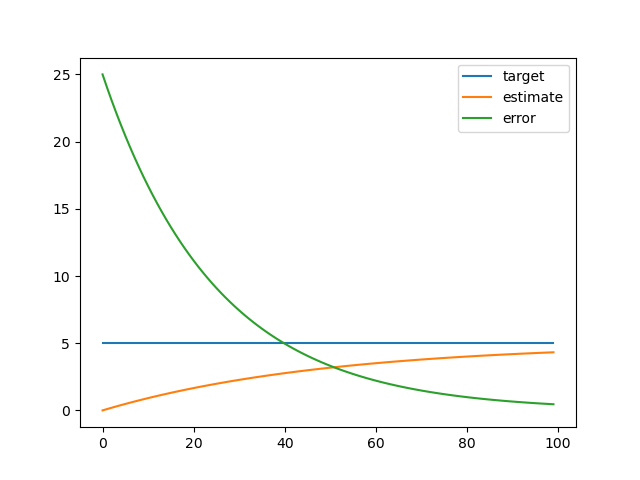

In [6]:
%matplotlib widget

learning_rate = 0.01

class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.estimate = torch.nn.Parameter(torch.zeros(1))
    def forward(self) -> torch.Tensor:
        return self.estimate

plot_data = defaultdict(lambda : [])

tinynet = TinyNet()
optimizer = torch.optim.SGD(tinynet.parameters(), lr = learning_rate)
loss = torch.nn.MSELoss()

## the remainder of this cell is the same as the code example above.
for _ in range(100):
    # target = torch.normal(5., 1., size=(1,))
    error = loss(tinynet(), target)
    error.backward()
    plot_data["target"].append(target.item())
    plot_data["estimate"].append(tinynet.estimate.item())
    plot_data["error"].append(error.item())
    optimizer.step()
    optimizer.zero_grad()

plt.figure("evolution over training iterations")
for type in plot_data.keys():
   plt.plot(plot_data[type], label=type)
plt.legend(loc='upper right')
pass

okay, now we have used a Module but why is it better? The answer is: for what we've done, it makes little difference. However, when models become more complex, the modular way enables us to plug larger NN-models together from smaller sub-modules. See e.g. the code on [MNIST](MNIST.ipynb).